In [41]:
from aif360.datasets import CompasDataset
from aif360.algorithms.inprocessing import PrejudiceRemover, MetaFairClassifier
from models import describe_metrics, SimpleMLP, FairTransitionLossMLP
from dataset_readers import describe_dataset
import fitness_rules
from fitness_rules import *
from aif360.metrics import ClassificationMetric
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [42]:
def eval(model, dataset, unprivileged_groups, privileged_groups, fitness_rule):
    try:
        # sklearn classifier
        y_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
        y_pred = (y_pred_prob[:, pos_ind] > 0.5).astype(np.float64)
    except AttributeError:
        # aif360 inprocessing algorithm
        y_pred = model.predict(dataset).labels

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    metric = ClassificationMetric(
        dataset, dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

    metrics = dict()
    metrics['overall_acc'] = abs(metric.accuracy())
    metrics['bal_acc'] = abs((metric.true_positive_rate()
                              + metric.true_negative_rate()) / 2)
    metrics['avg_odds_diff'] = metric.average_abs_odds_difference()
    metrics['disp_imp'] = abs(metric.disparate_impact())
    metrics['stat_par_diff'] = abs(metric.statistical_parity_difference())
    metrics['eq_opp_diff'] = abs(metric.equal_opportunity_difference())
    metrics['theil_ind'] = abs(metric.theil_index())
    metrics['f1_score'] = metric.f1_score()
    metrics.update(metric.performance_measures())
    metrics['fitness'] = fitness_rule(metrics)
    return metrics

In [43]:
data = CompasDataset()
(dataset_train,
 dataset_test) = data.split([0.8])

sens_ind = 1
sens_attr = dataset_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_train.privileged_protected_attributes[sens_ind]]

describe_dataset(dataset_train, dataset_test, dataset_test)

#### Training Dataset shape
(4933, 401)
#### Validation Dataset shape
(1234, 401)
#### Test Dataset shape
(1234, 401)
#### Favorable and unfavorable labels
0.0 1.0
#### Protected attribute names
['sex', 'race']
#### Privileged and unprivileged protected attribute values
[array([1.]), array([1.])] [array([0.]), array([0.])]
#### Dataset feature names
['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age_cat=25 - 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'c_charge_degree=F', 'c_charge_degree=M', 'c_charge_desc=Abuse Without Great Harm', 'c_charge_desc=Agg Abuse Elderlly/Disabled Adult', 'c_charge_desc=Agg Assault W/int Com Fel Dome', 'c_charge_desc=Agg Battery Grt/Bod/Harm', 'c_charge_desc=Agg Fleeing and Eluding', 'c_charge_desc=Agg Fleeing/Eluding High Speed', 'c_charge_desc=Aggr Child Abuse-Torture,Punish', 'c_charge_desc=Aggrav Battery w/Deadly Weapon', 'c_charge_desc=Aggrav Child Abuse-Agg Battery', 'c_charge_desc=Aggrav Chil

In [44]:
scaler = StandardScaler()
dataset_train.features = scaler.fit_transform(dataset_train.features)
dataset_test.features = scaler.transform(dataset_test.features)

In [45]:


model = FairTransitionLossMLP(sensitive_attr=sens_attr, num_epochs=50, hidden_sizes=[300,300,300],
                              dropout=0.2, privileged_demotion=0.5551602487668974,
                              privileged_promotion=0.6439614948511146, protected_demotion=0.30423795961025624,
                              protected_promotion=0.7967811248525456)
model = model.fit(dataset_train, verbose=True)

Epoch 1/50
70/70 [==============================] - 1s 6ms/step - loss: 0.7552 - val_loss: 0.7554
Epoch 2/50
70/70 [==============================] - 0s 4ms/step - loss: 0.7496 - val_loss: 0.7554
Epoch 3/50
70/70 [==============================] - 0s 4ms/step - loss: 0.7496 - val_loss: 0.7554
Epoch 4/50
70/70 [==============================] - 0s 5ms/step - loss: 0.7496 - val_loss: 0.7554
Epoch 5/50
70/70 [==============================] - 0s 5ms/step - loss: 0.7496 - val_loss: 0.7554
Epoch 6/50
70/70 [==============================] - 0s 5ms/step - loss: 0.7496 - val_loss: 0.7554
Epoch 7/50
70/70 [==============================] - 0s 5ms/step - loss: 0.7496 - val_loss: 0.7554
Epoch 8/50
70/70 [==============================] - 0s 4ms/step - loss: 0.7496 - val_loss: 0.7554
Epoch 9/50
70/70 [==============================] - 0s 4ms/step - loss: 0.7496 - val_loss: 0.7554
Epoch 10/50
70/70 [==============================] - 0s 4ms/step - loss: 0.7496 - val_loss: 0.7554
Epoch 11/50
70/70 [

<Axes: >

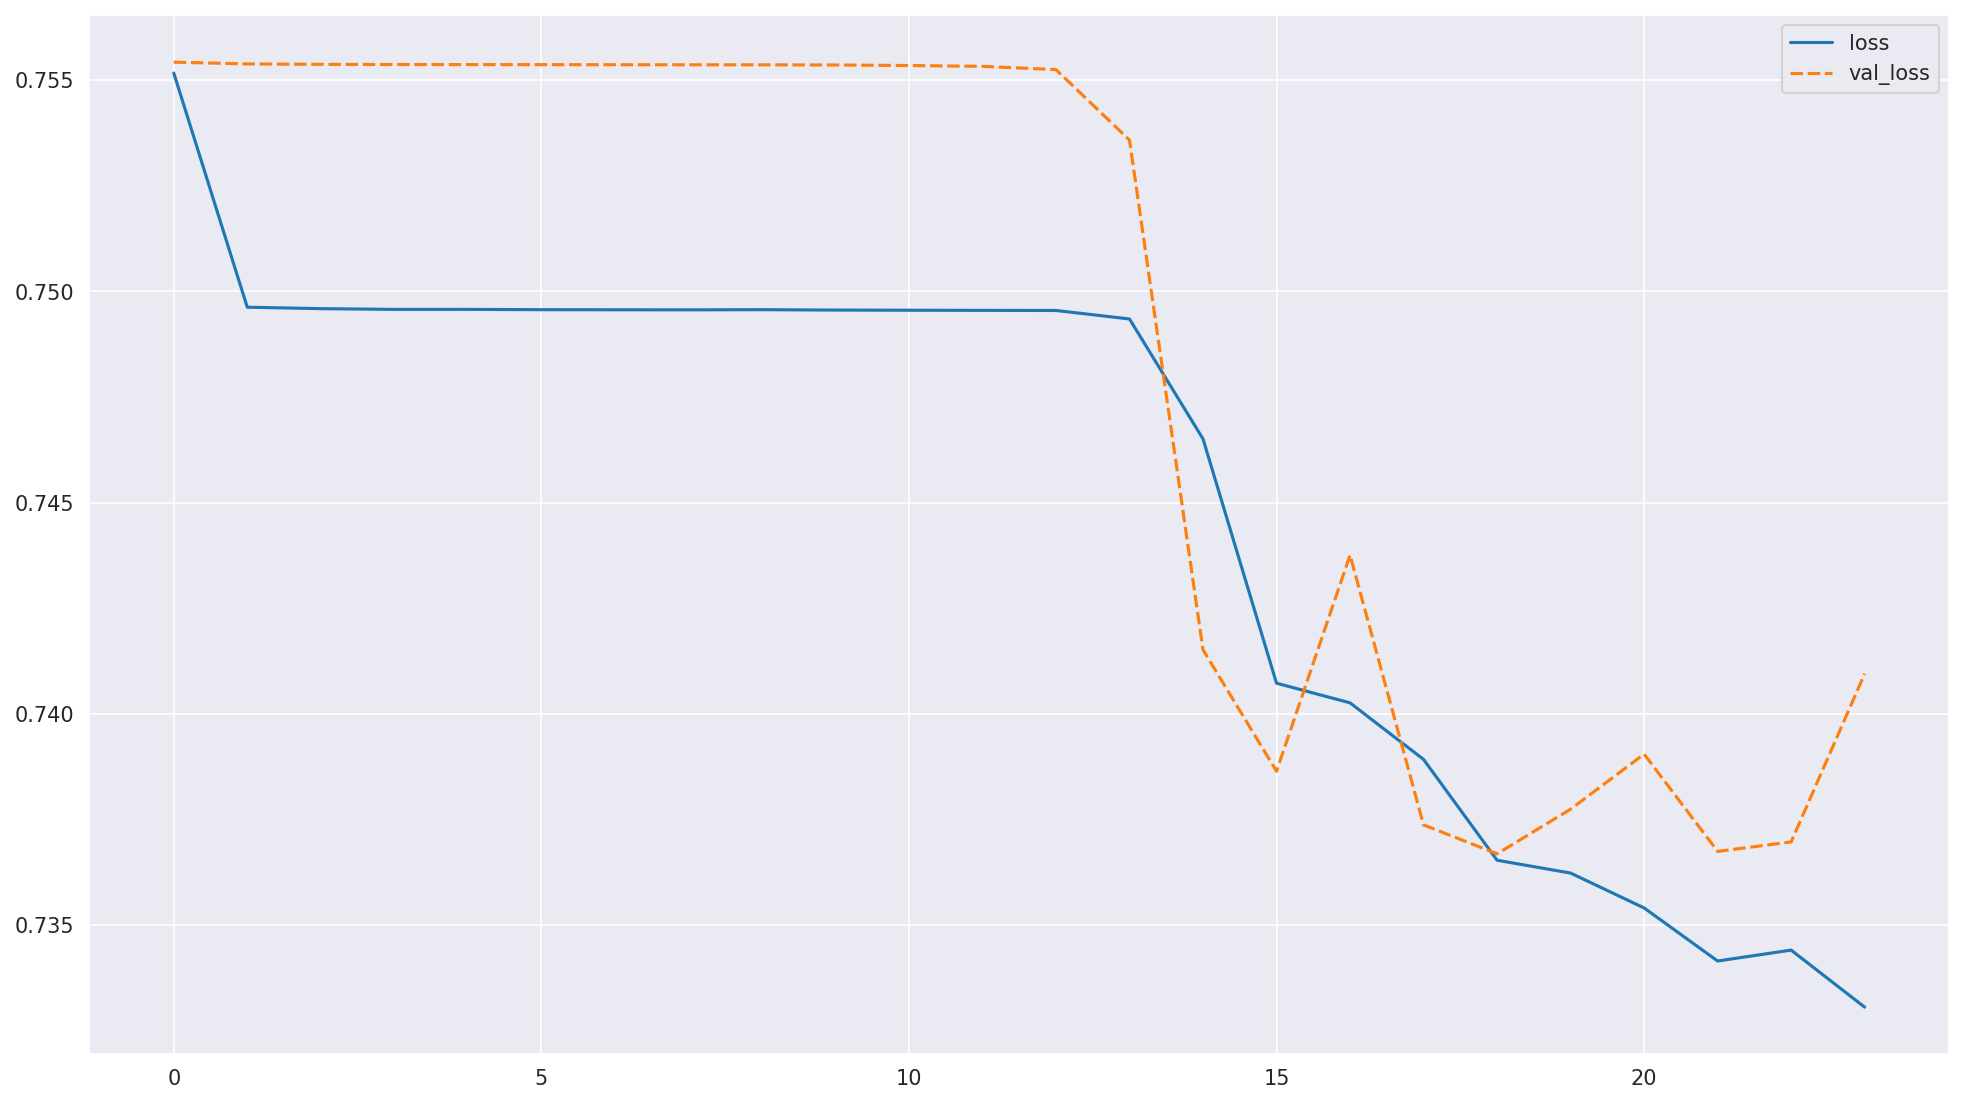

In [46]:
fig, ax = plt.subplots(figsize=(16, 9), dpi = 150)
sns.lineplot(model.history.history, ax=ax)

In [47]:
val_metrics = eval(model, dataset_test, unprivileged_groups, privileged_groups, mcc_odds)
describe_metrics(val_metrics)

39/39 [==============================] - 0s 767us/step
Fitness: 0.1350
Overall accuracy: 0.5964
F1 Score: 0.7108
Mathew Correlation Coefficient: 0.1873
Balanced accuracy: 0.5666
Average odds difference value: 0.0522
Statistical parity difference value: 0.0370
Equal opportunity difference value: 0.0755
